In [35]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import logging
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import os
import pickle
import logging
import copy
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VAE_MNIST(nn.Module):
  def __init__(self, x_dim, h1_dim, h2_dim, z_dim):
    super(VAE_MNIST, self).__init__()
    self.FC1 = nn.Linear(x_dim + 10, h1_dim)
    self.FC2 = nn.Linear(h1_dim, h2_dim)
    self.FC3_mu = nn.Linear(h2_dim, z_dim)
    self.FC3_sigma = nn.Linear(h2_dim, z_dim)

    self.FC4 = nn.Linear(z_dim + 10, h2_dim)
    self.FC5 = nn.Linear(h2_dim, h1_dim)
    self.FC6 = nn.Linear(h1_dim, x_dim)

    self.z_dim = z_dim

  def encoder(self, x, one_hot_class):
    x = torch.cat((x, one_hot_class), 1)
    x = F.relu(self.FC1(x))
    x = F.relu(self.FC2(x))
    mu = self.FC3_mu(x)
    sigma = self.FC3_sigma(x)
    return mu, sigma
  def decoder(self, z, one_hot_class):
    x = torch.cat((z, one_hot_class), 1)
    x = F.relu(self.FC4(x))
    x = F.relu(self.FC5(x))
    x = torch.sigmoid(self.FC6(x))
    return x
  def sampler(self, mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps
  def forward(self, x, one_hot_class):
    mu, sigma = self.encoder(x.view(-1,784), one_hot_class)
    z = self.sampler(mu, sigma)
    x = self.decoder(z, one_hot_class)
    return x, mu, sigma
  def info_vae(self):
    return self.z_dim

In [11]:
def loss_function(x, x_hat, mu, sigma):
  BCE = F.binary_cross_entropy(x_hat, x.view(-1,784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
  return BCE + KLD
def train(model, num_batch_iter, train_iter, optimizer, logging_freq, test_loader):
  model.train()
  train_loss = 0
  for iter in tqdm(range(num_batch_iter)):
    x, cls = next(train_iter)
    one_hot_class = F.one_hot(cls, num_classes=10)
    x = x.to(device)
    one_hot_class = one_hot_class.to(device)
    optimizer.zero_grad()
    x_hat, mu, sigma = model(x, one_hot_class)
    loss = loss_function(x, x_hat, mu, sigma)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    if iter % logging_freq == 0:
      model.eval()
      with torch.no_grad():
        z = torch.randn(10, model.info_vae()).to(device)
        c =  torch.arange(10)
        c = F.one_hot(c, num_classes=10).to(device)
        x_hat = model.decoder(z, c).view(10, 1, 28,28)
        grid = make_grid(x_hat, nrow = 10)
        save_image(grid, os.path.join("output/", "step_" + str(iter) + ".png"))
        np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.title(f'Step {iter}')
        plt.axis('off')
        plt.show()
def test(model,test_loader):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for x, cls in test_loader:
      cls = F.one_hot(cls, 10)
      x = x.to(device)
      cls = cls.to(device)
      x_hat, mu, sigma = model(x, cls)
      test_loss += loss_function(x, x_hat, mu, sigma).item()
  return test_loss/len(test_loader)
def cycle(dl):
  while True:
      for data in dl:
          yield data

  0%|          | 0/100000 [00:00<?, ?it/s]

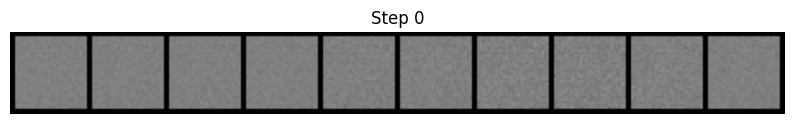

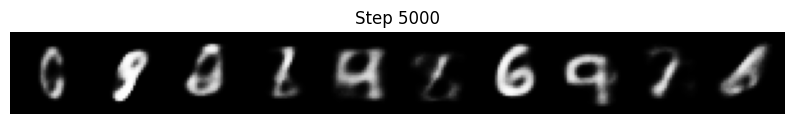

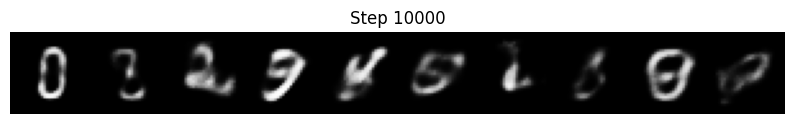

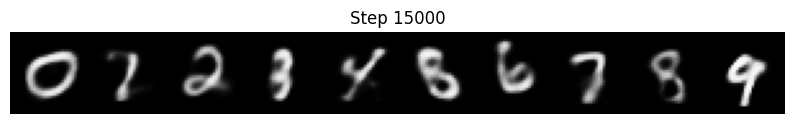

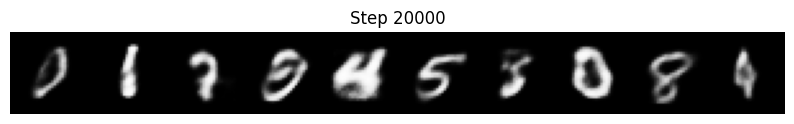

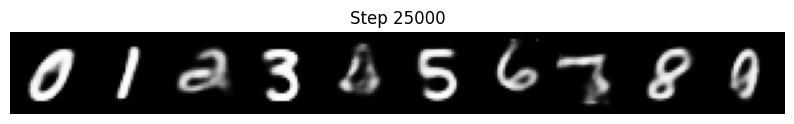

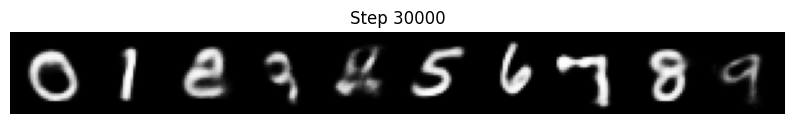

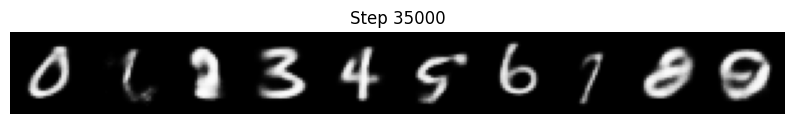

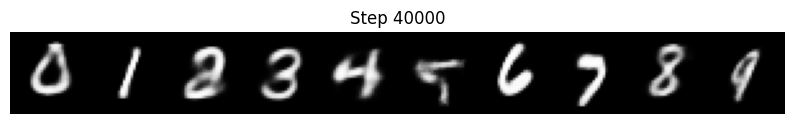

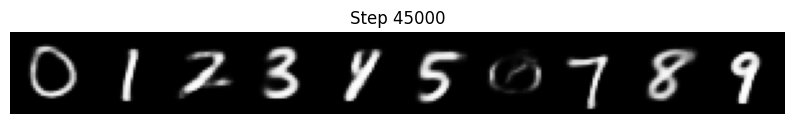

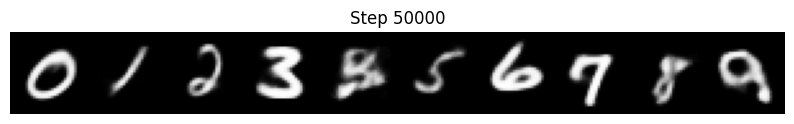

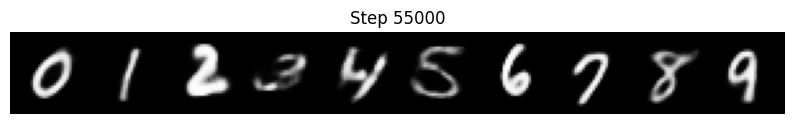

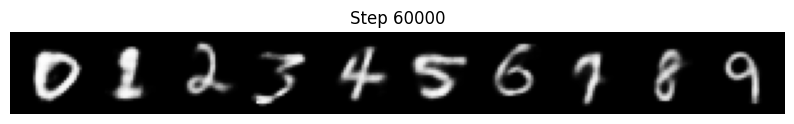

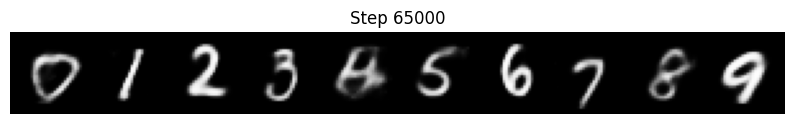

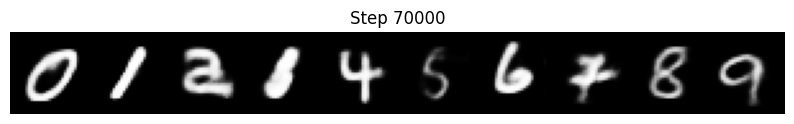

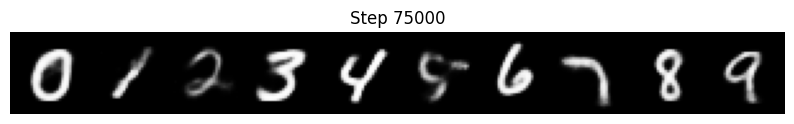

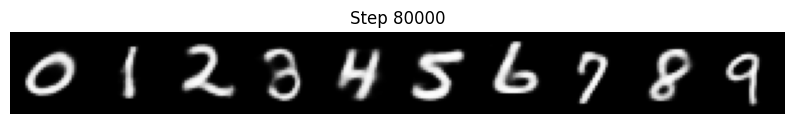

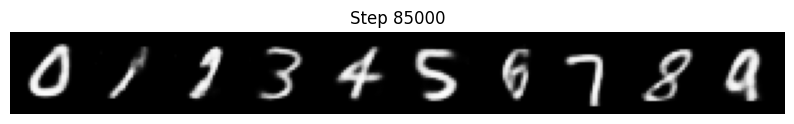

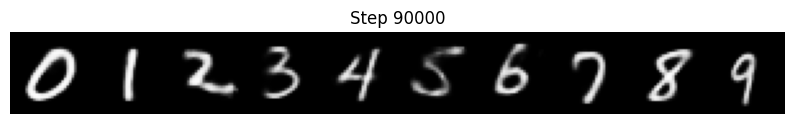

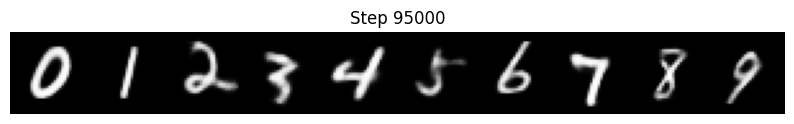

Training complete. Saving model...
Model saved to vae_mnist_final.pth


In [12]:
train_dataset = datasets.MNIST(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
train_iter = cycle(train_loader)
vae = VAE_MNIST(x_dim=28 * 28, h1_dim= 512, h2_dim=256, z_dim=8)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

n_iters = 100000
log_freq = 5000
train(vae, n_iters, train_iter, optimizer, log_freq, test_loader)
print("Training complete. Saving model...")
MODEL_PATH = "vae_mnist_final.pth"
torch.save(vae.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

In [24]:
def calculate_fim(model, n_samples):
  fisher_diag = {}
  for name, param in model.named_parameters():
      fisher_diag[name] = torch.zeros_like(param.data)
  model.eval()
  for i in range(n_samples):
    with torch.no_grad():
      z = torch.randn(1, model.info_vae()).to(device)
      c =  torch.randint(0,10, (1,))
      c = F.one_hot(c, num_classes=10).to(device)
      model.eval()
      x = model.decoder(z, c)
    model.train()
    model.zero_grad()
    x_hat, mu, sigma = vae(x, c)
    loss = loss_function(x, x_hat, mu, sigma)
    loss.backward()
    for name, param in model.named_parameters():
      if torch.isnan(param.grad.data).any():
        print("NAN")
      fisher_diag[name] += ((param.grad.data).pow(2) ) / n_samples
  with open(os.path.join("output/", 'fisher_diag.pkl'), 'wb') as f:
        pickle.dump(fisher_diag, f)
  return fisher_diag

In [ ]:
fisher_dict = calculate_fim(vae, 50000)

In [49]:
def forget_train(model, num_batch_iter, optimizer, logging_freq, drop_label, fisher_dict, params_mle_dict, lmbda):
  model_dup = copy.deepcopy(model)
  model_dup.eval()
  label_choices = list(range(10))
  label_choices.remove(drop_label)
  model.train()
  for iter in tqdm(range(num_batch_iter)):
    c_remember = torch.from_numpy(np.random.choice(label_choices, size=256)).to(device)
    c_remember = F.one_hot(c_remember, 10)
    z_remember = torch.randn((256, 8)).to(device)
    c_forget = (torch.ones(256, dtype=int) * drop_label).to(device)
    c_forget = F.one_hot(c_forget, 10)
    out_forget = torch.rand((256, 1, 28, 28)).to(device)
    with torch.no_grad():
      out_remember = model_dup.decoder(z_remember, c_remember).view(-1,1,28,28)
    optimizer.zero_grad()
    x_hat, mu, sigma = model(out_forget, c_forget)
    loss = loss_function(out_forget, x_hat, mu, sigma)

    x_hat, mu, sigma = model(out_remember, c_remember)
    loss += loss_function(out_remember,x_hat, mu, sigma)
    for name, param in model.named_parameters():
      fish_loss = fisher_dict[name].to(device) * (param - params_mle_dict[name].to(device)).pow(2)
      loss += lmbda * fish_loss.sum()
    if iter % logging_freq == 0:
      model.eval()
      with torch.no_grad():
        z = torch.randn(10, model.info_vae()).to(device)
        c =  torch.arange(10)
        c = F.one_hot(c, num_classes=10).to(device)
        x_hat = model.decoder(z, c).view(10, 1, 28,28)
        grid = make_grid(x_hat, nrow = 10)
        save_image(grid, os.path.join("output/", "step_" + str(iter) + ".png"))
        np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.title(f'Step {iter}')
        plt.axis('off')
        plt.show()
    loss.backward()
    optimizer.step()

In [50]:
vae.load_state_dict(torch.load(MODEL_PATH))
with open(os.path.join("output/", 'fisher_diag.pkl'), 'rb') as f:
  fisher_dict = pickle.load(f)
params_mle_dict = {}
for name, param in vae.named_parameters():
    params_mle_dict[name] = param.data.clone()

  0%|          | 0/10000 [00:00<?, ?it/s]

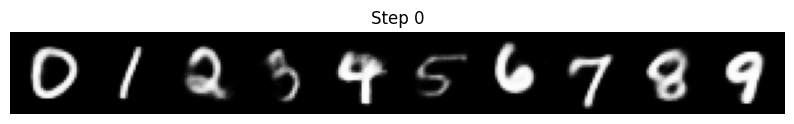

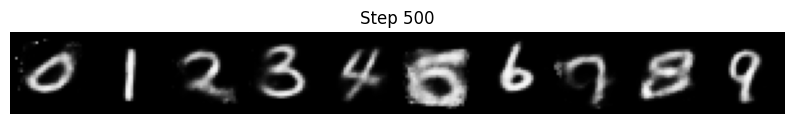

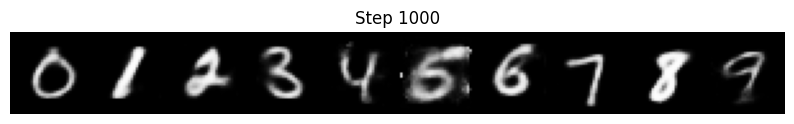

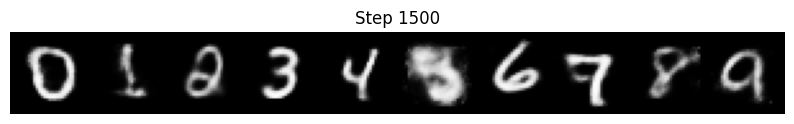

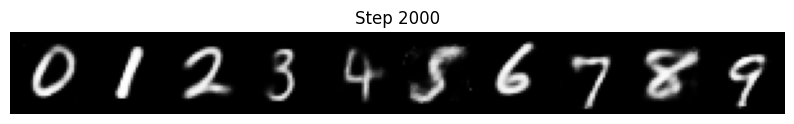

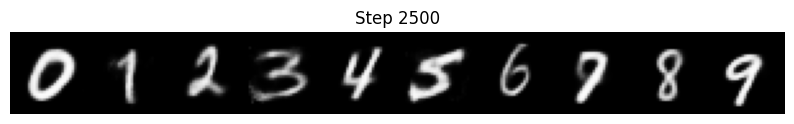

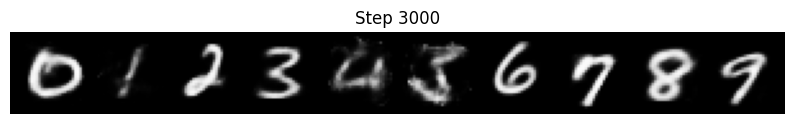

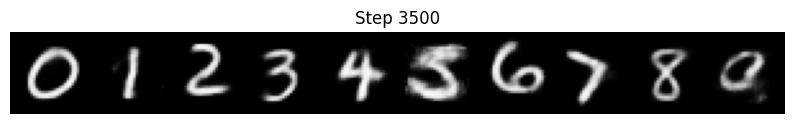

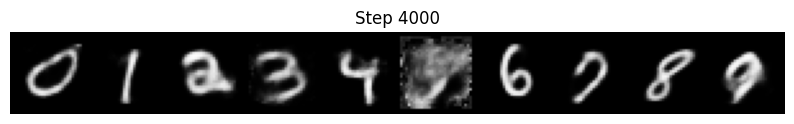

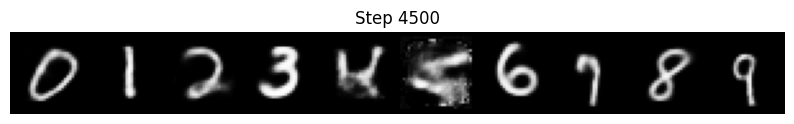

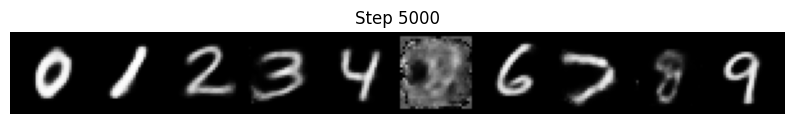

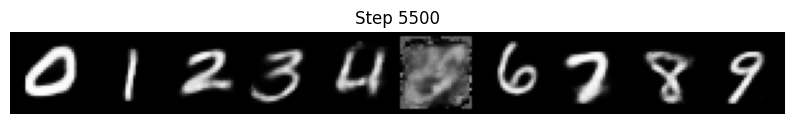

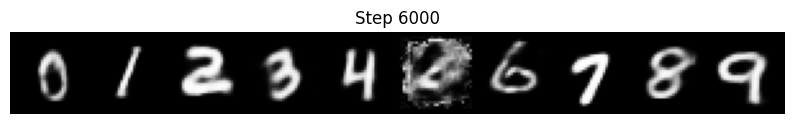

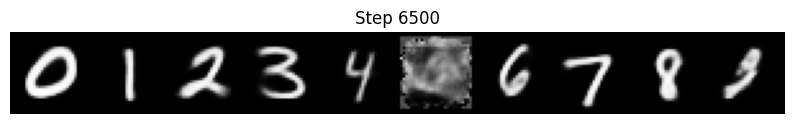

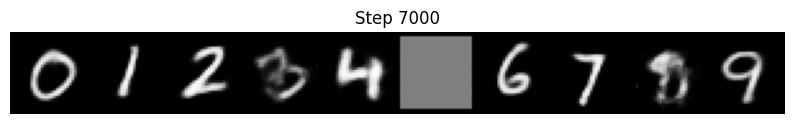

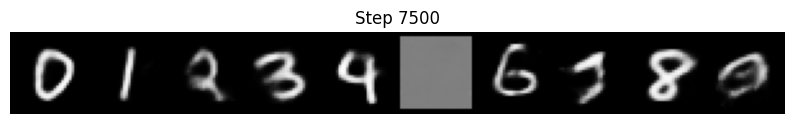

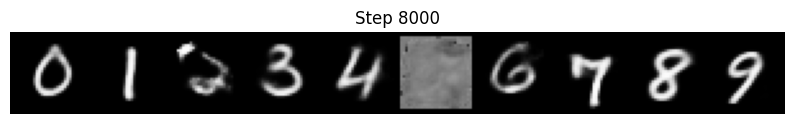

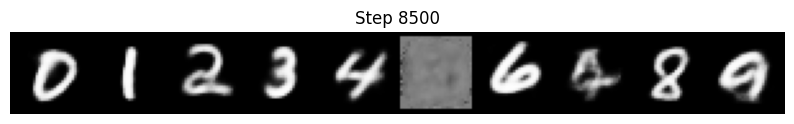

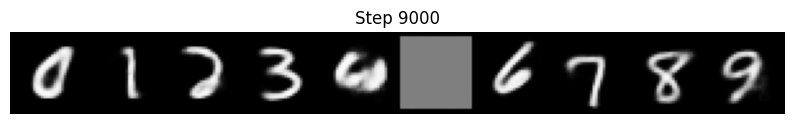

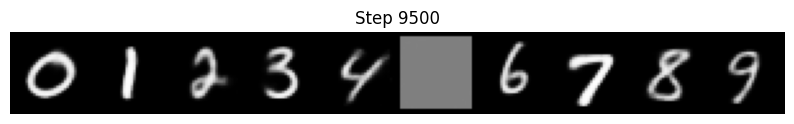

In [51]:
lmbda = 100
n_iter = 10000
freq = 500
lr = 0.0001
forget_train(vae, n_iter, optimizer, freq, 5, fisher_dict, params_mle_dict, lmbda)